In [633]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential



In [591]:
# Use to restrict x-axis when displaying time-related data
DATE_RANGE = (pd.to_datetime('2016-09'), pd.to_datetime('2019-06-01'))

FIG_SIZE = (10, 6)
PALETTE = sns.color_palette()
plt.rcParams['figure.figsize'] = FIG_SIZE

def savefig(fig, name):
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

### Load Dataset

In [592]:
df = pd.read_csv("../data/pre_issuedata.csv.gz", compression='gzip')
df

,Unnamed: 0,message,filepath,line,column,kind,snippet,end_column,workflow_content,repository,...,date,workflow,change_type,lines_count,commit_year,commit_mon_year,next_commit,status,time_taken,Rule
0,0,"unexpected key ""actions"" for ""job"" section. ex...",eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,7,5,syntax-check,actions:\n ^~~~~~~~,12,eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,actions---toolkit,...,2019-07-11 22:14:13,.github/workflows/workflow.yml,A,52,2019,2019-07,1688b117e1fb7715c3879a29496a7562cf57dfca,closed,286 days 22:38:40,Readability and Maintainability Issues
1,1,"unexpected key ""actions"" for ""job"" section. ex...",eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,33,5,syntax-check,actions:\n ^~~~~~~~,12,eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,actions---toolkit,...,2019-07-11 22:14:13,.github/workflows/workflow.yml,A,52,2019,2019-07,1688b117e1fb7715c3879a29496a7562cf57dfca,closed,286 days 22:38:40,Readability and Maintainability Issues
2,2,"""steps"" section is missing in job ""Windows""",eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,30,3,syntax-check,Windows:\n ^~~~~~~~,10,eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,actions---toolkit,...,2019-07-11 22:14:13,.github/workflows/workflow.yml,A,52,2019,2019-07,1688b117e1fb7715c3879a29496a7562cf57dfca,closed,286 days 22:38:40,Readability and Maintainability Issues
3,3,"""steps"" section is missing in job ""Ubuntu""",eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,4,3,syntax-check,Ubuntu:\n ^~~~~~~,9,eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...,actions---toolkit,...,2019-07-11 22:14:13,.github/workflows/workflow.yml,A,52,2019,2019-07,1688b117e1fb7715c3879a29496a7562cf57dfca,closed,286 days 22:38:40,Readability and Maintainability Issues
4,4,"workflow command ""set-env"" was deprecated. use...",039caf0a23b2880cc6df745d11bda55cd77af51cac105a...,41,12,deprecated-commands,run: |\n ^,12,039caf0a23b2880cc6df745d11bda55cd77af51cac105a...,actions---toolkit,...,2020-04-23 20:52:53,.github/workflows/artifact-tests.yml,A,78,2020,2020-04,628f82f22156d17814bfe7876fe3581456e9a9f3,open,unresolved error,Error Handling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128854,1128854,"label ""ubuntu-22.04-8core"" is unknown. availab...",e8b89e16721022c609b3d3f9697754a0307204fae774ac...,23,11,runner-label,- ubuntu-22.04-8core\n ^~~~~~...,28,e8b89e16721022c609b3d3f9697754a0307204fae774ac...,flox---flox,...,2023-10-10 21:39:58,.github/workflows/ci.yml,M,52,2023,2023-10,d4a272dba0fc0b5c46fc89ded4b95451515d945e,open,unresolved error,Configurations issue in the workflow
1128855,1128855,"label ""ubuntu-22.04-8core"" is unknown. availab...",b2244ee2d58022030d84b50d99d135f62336918588c0c4...,24,11,runner-label,- ubuntu-22.04-8core\n ^~~~~~...,28,b2244ee2d58022030d84b50d99d135f62336918588c0c4...,flox---flox,...,2023-10-11 18:58:53,.github/workflows/ci.yml,M,55,2023,2023-10,NaN,closed,unresolved error,Configurations issue in the workflow
1128856,1128856,"workflow command ""set-output"" was deprecated. ...",ae722a26cf35b3eed11746e51610381acf6e9534e9b010...,95,14,deprecated-commands,run: |\n ^,14,ae722a26cf35b3eed11746e51610381acf6e9534e9b010...,intelligent-machine-learning---dlrover,...,2023-10-11 11:28:42,.github/workflows/main.yml,M,117,2023,2023-10,NaN,closed,unresolved error,Error Handling
1128857,1128857,"property ""workspace"" is not defined in object ...",e68a0e6591fd3e1c4b4b84b0755997ba8b0dbabad75208...,20,40,expression,run: |,40,e68a0e6591fd3e1c4b4b84b0755997ba8b0dbabad75208...,galkahana---pdf-writer,...,2023-10-11 12:21:27,.github/workflows/ci-xmake-linux.yml,A,42,2023,2023-10,NaN,closed,unresolved error,Inefficient code


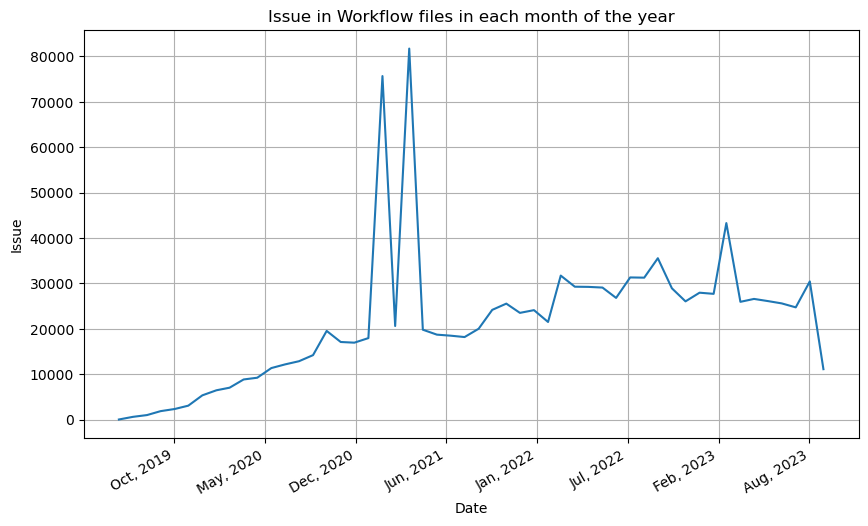

In [593]:
fig, ax = plt.subplots(figsize=(10, 6))

# gettinig the number of issues per month in the year
no_of_issue = (
    df
    .groupby(['commit_mon_year'], sort=True)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

# converting the date to numeric
dates = mdates.date2num(no_of_issue.index)

ax.plot(dates, no_of_issue['no_of_issue'])
ax.set_title('Issue in Workflow files in each month of the year')
ax.set_xlabel('Date')
ax.set_ylabel('Issue')


# Add the grid
plt.grid(True)

# Format x-axis labels as dates
date_form = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(date_form)

# ax.xaxis.set_major_locator(half_year_locator)

plt.gcf().autofmt_xdate()

plt.show()

In [594]:
df['kind'].value_counts()

deprecated-commands    368212
expression             292188
syntax-check           217987
runner-label           134139
yaml-syntax             37298
matrix                  23520
events                  18617
action                  15106
pyflakes                 8648
glob                     7117
job-needs                3252
id                       1347
shell-name                632
env-var                   401
permissions               235
workflow-call             160
Name: kind, dtype: int64

In [595]:
df['Rule'].value_counts()

Error Handling                            376888
Inefficient code                          271684
Configurations issue in the workflow      234224
Readability and Maintainability Issues    171645
Lack of Automated tests                    45316
Security vulnerabilities in code           12920
Compatibility issues                        9073
Code duplication                            7109
Name: Rule, dtype: int64

In [596]:
df['message'].nunique()

35325

In [597]:
df.columns

Index(['Unnamed: 0', 'message', 'filepath', 'line', 'column', 'kind',
       'snippet', 'end_column', 'workflow_content', 'repository', 'commit',
       'author_name', 'author_email', 'commiter_name', 'commiter_email',
       'date', 'workflow', 'change_type', 'lines_count', 'commit_year',
       'commit_mon_year', 'next_commit', 'status', 'time_taken', 'Rule'],
      dtype='object')

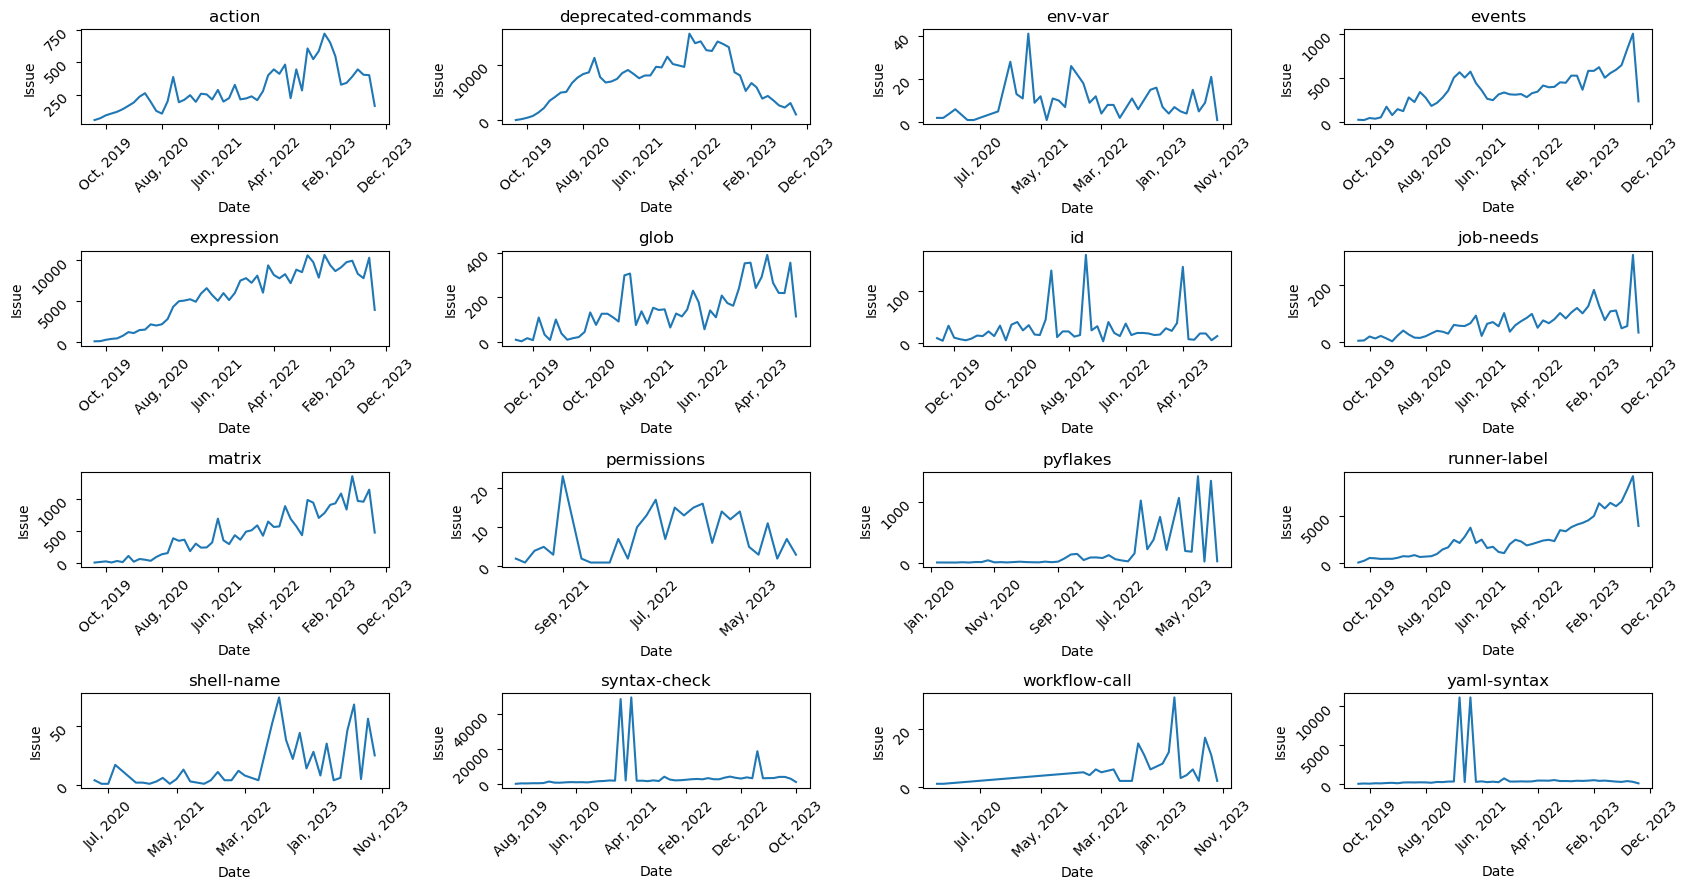

In [598]:
no_issue_kind = (
    df
    .groupby(['kind','commit_mon_year'], as_index=False)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

kinds = no_issue_kind['kind'].unique()

def plotnew(ax, kind):
    data = no_issue_kind[no_issue_kind['kind'] == kind]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')
   
    ax.set_title(kind)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=4, ncols=4)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plotnew(ax, kinds[i])
    
# plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

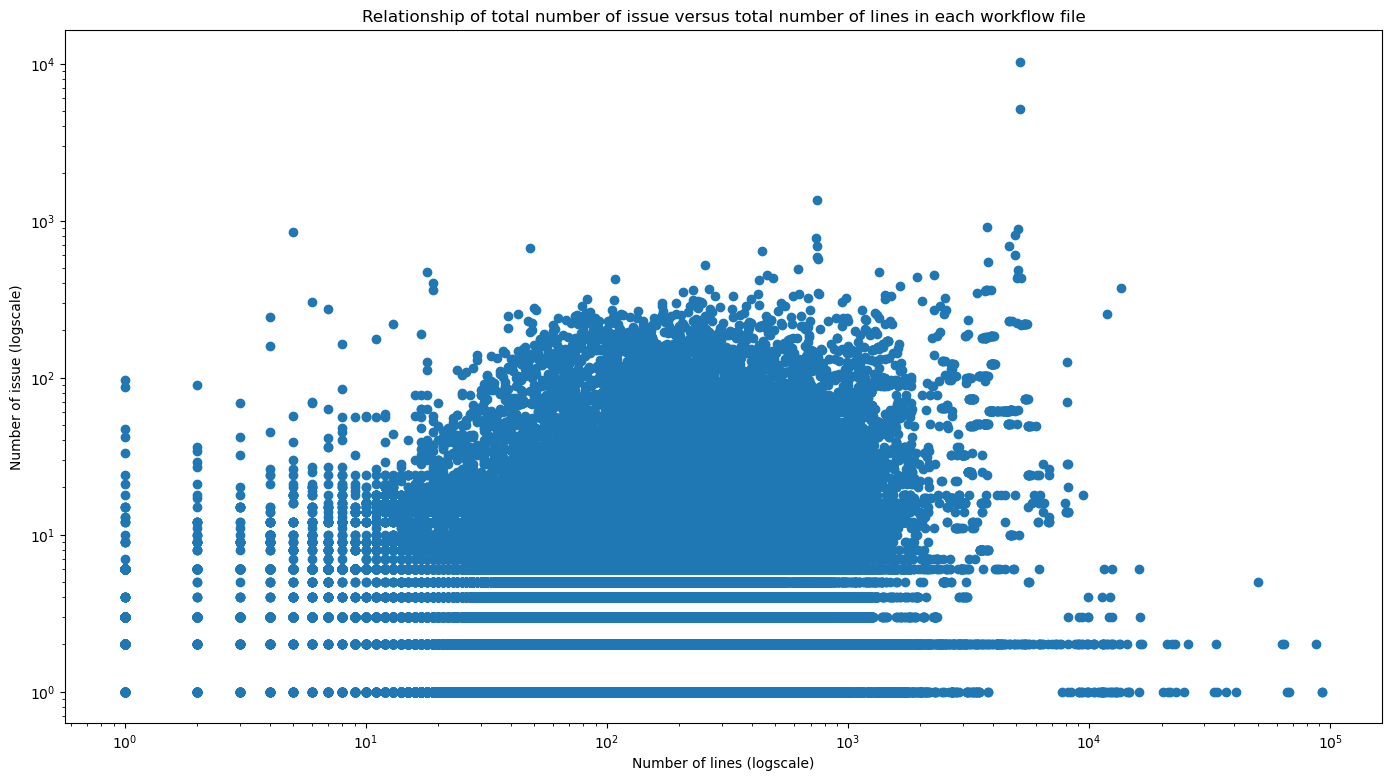

In [599]:
wf_issue_count = (
    df
    .groupby(['workflow','lines_count'], as_index=False)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

plt.scatter(x=wf_issue_count['lines_count'], y=wf_issue_count['no_of_issue'])
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Relationship of total number of issue versus total number of lines in each workflow file')
plt.xlabel('Number of lines (logscale)')
plt.ylabel('Number of issue (logscale)')

plt.yscale("log")
plt.xscale("log")


plt.show()

In [572]:
# def calculate_time(repository, dataset):
#     dataset['time_diff'] = ""
#     dataset = dataset[dataset['repository'] == repository]
    
#     for index, row in dataset.iterrows():
#         print("The index is :{} and the row is :{}".format(index,row))
#         df_commit = dataset[dataset['commit'] == row.commit ]
#         df_commit_next = dataset[dataset['commit'] == row.next_commit ]
#         print("The commit dataframe is: {}".format(df_commit.status))
#         print("The result of the any for the commit is : {}".format(any(df_commit.status == 'closed')))
#         print("The next commit dataframe is: {}".format(df_commit_next.status))
#         print("The result of the any for the next commit is : {}".format(all(df_commit_next.status)))
        
#         if (df_commit.status == "closed").all():
#             print("The commit in the if statement is:{}".format(df_commit))
#             time_in = df_commit['date'] - df_commit_next['date']
#             print("The commit:{} time is :{}".format(time_in,df_commit.commit))
#         elif (df_commit.status == "open").any():
#             print("The commit in the elif statement:{}".format(df_commit))
#             time_out = df_commit_next['date'] - df_commit['date']
#             print("The next commit:{} time is :{}".format(time_out, df_commit_next.commit))
            
    

In [603]:
df_group_rule = (df.groupby('Rule').agg({'Rule': 'count'})
    .rename(columns={'date': 'no_of_issue'}))
df_group_rule


,Rule
Rule,
Code duplication,7109
Compatibility issues,9073
Configurations issue in the workflow,234224
Error Handling,376888
Inefficient code,271684
Lack of Automated tests,45316
Readability and Maintainability Issues,171645
Security vulnerabilities in code,12920


In [604]:
df['Rule'].value_counts()

Error Handling                            376888
Inefficient code                          271684
Configurations issue in the workflow      234224
Readability and Maintainability Issues    171645
Lack of Automated tests                    45316
Security vulnerabilities in code           12920
Compatibility issues                        9073
Code duplication                            7109
Name: Rule, dtype: int64

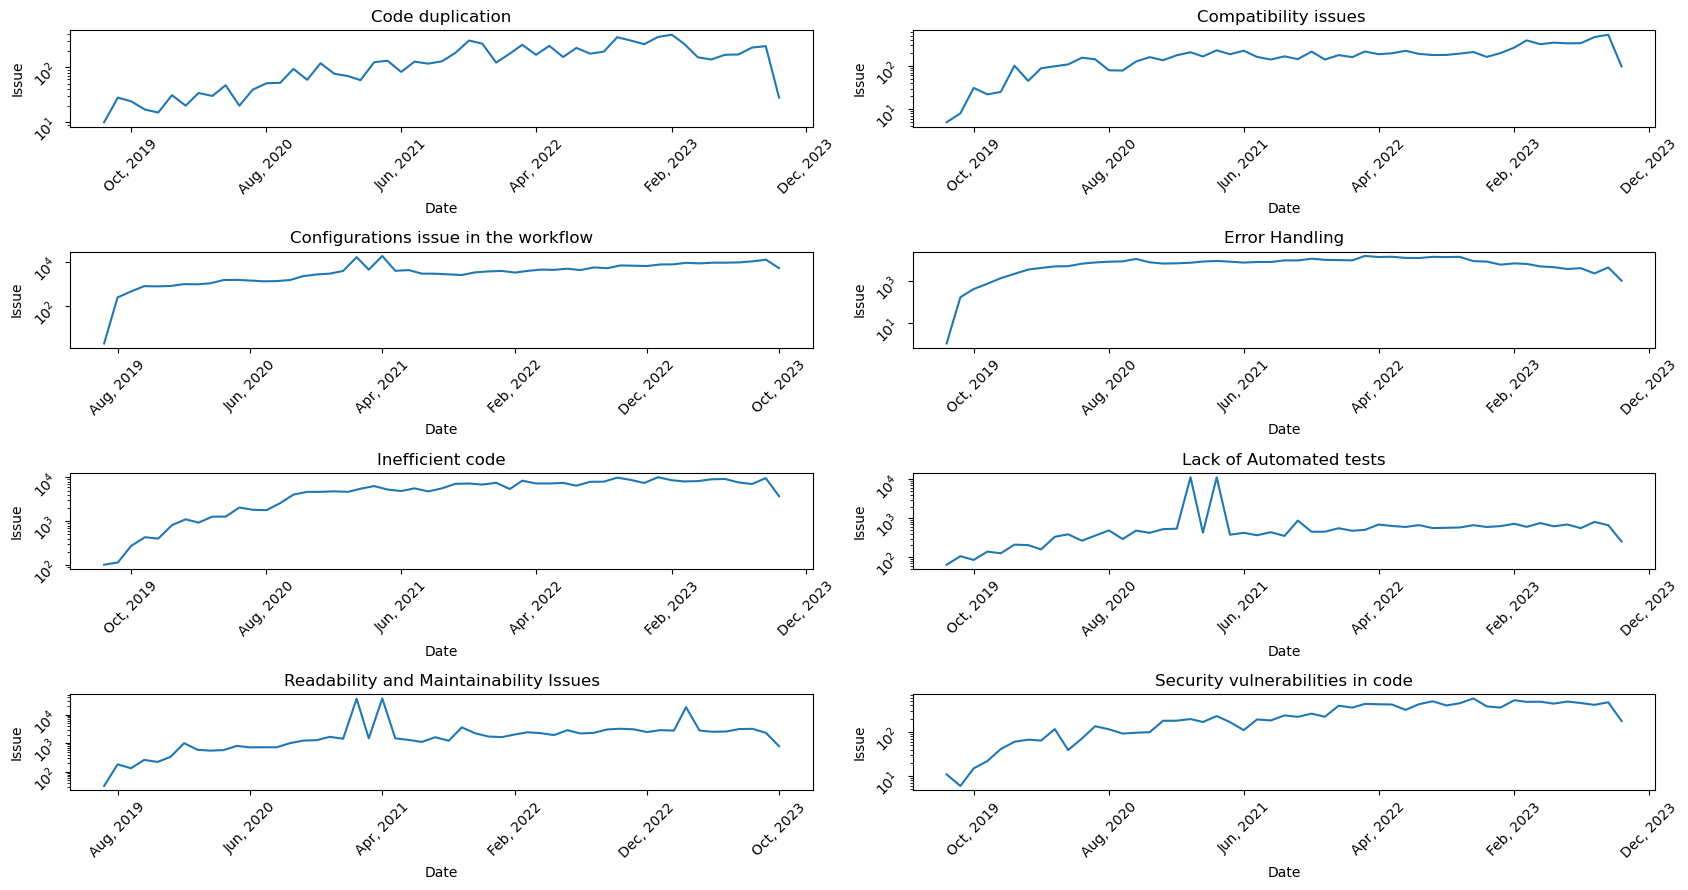

In [605]:
no_issue_rule = (
    df
    .groupby(['Rule','commit_mon_year'], as_index=False)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

rule = no_issue_rule['Rule'].unique()

def plot_unique_rule(ax, rule):
    data = no_issue_rule[no_issue_rule['Rule'] == rule]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')

    
    ax.set_yscale('log')
    
    ax.set_title(rule)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=4, ncols=2)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plot_unique_rule(ax, rule[i])
    
# plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [623]:
no_issue_per_year = (
    df
    .groupby(['Rule', 'commit_year'], as_index=False)
    .agg({'commit': 'count'})
    .rename(columns={'commit': 'issue'})
)


The data is:[  94  594 1663 2626 2132]
The data is:[  91 1313 2149 2263 3257]
The data is:[ 3019 19024 67539 58169 86473]
The data is:[  2644  76912 104847 148103  44382]
The data is:[ 1327 27175 69098 92305 81779]
The data is:[  520  4125 27294  7086  6291]
The data is:[ 1163 10846 89478 29269 40889]
The data is:[  95 1133 2362 5052 4278]


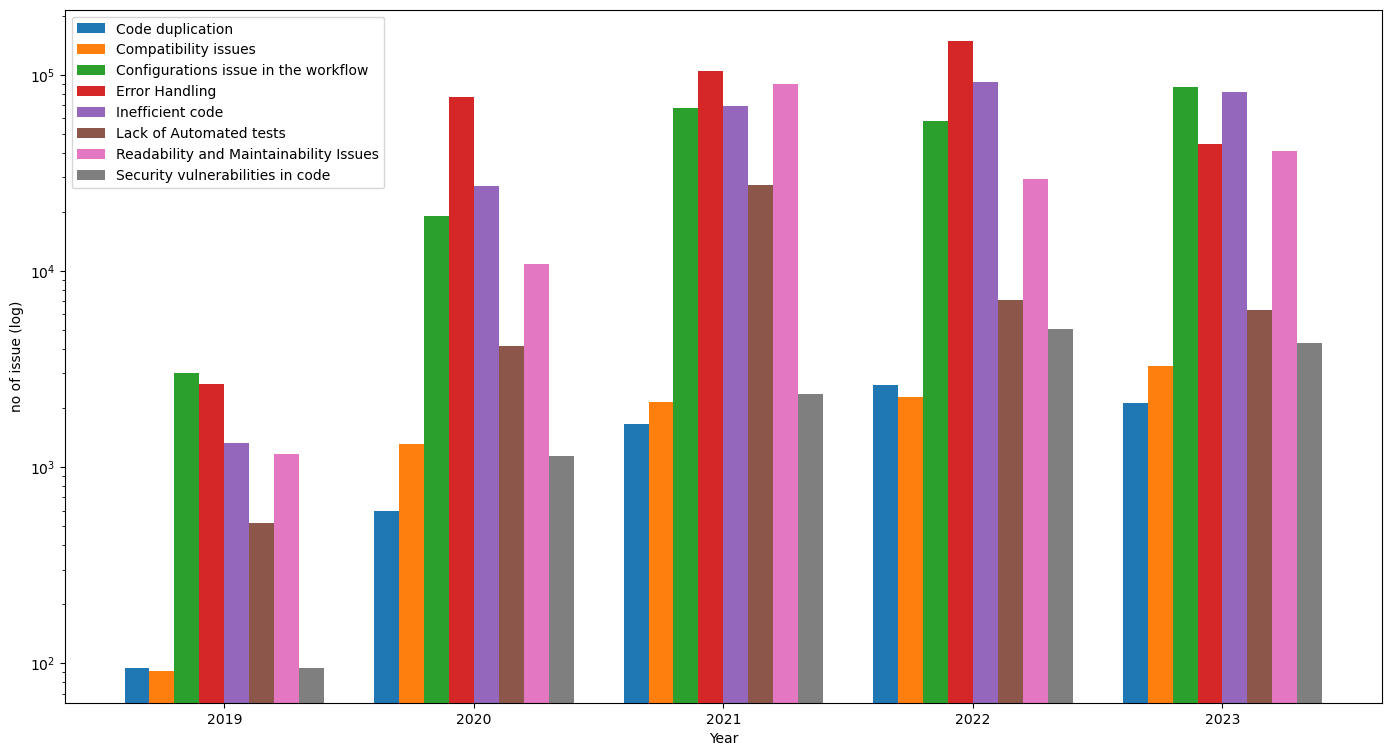

In [625]:
N = 5
ind = np.arange(N)  
width = 0.1
# plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})  

bars = []
for i, rule in enumerate(no_issue_per_year['Rule'].unique()):
    data = no_issue_per_year[no_issue_per_year['Rule'] == rule]
    print("The data is:{}".format(data['issue'].values))
    bars.append(plt.bar(ind + width * i, data['issue'].values, width))
#     plt.bar_label(bars[i], padding = 15)
#     break
    
plt.xlabel("Year")
plt.ylabel('no of issue (log)')
plt.yscale('log')
# plt.title("Players Score")

plt.xticks(ind + width * (N - 1.5), no_issue_per_year['commit_year'].unique())

legend_labels = no_issue_per_commit['Rule'].unique()
plt.legend(bars, legend_labels)

plt.show()

In [611]:
no_issue_per_commit

,Rule,commit_year,no_of_commit
0,Code duplication,2019,94
1,Code duplication,2020,594
2,Code duplication,2021,1663
3,Code duplication,2022,2626
4,Code duplication,2023,2132
5,Compatibility issues,2019,91
6,Compatibility issues,2020,1313
7,Compatibility issues,2021,2149
8,Compatibility issues,2022,2263
9,Compatibility issues,2023,3257


## Average time taken for each Rule to reslove the issue

Text(0.5, 1.0, 'Time Taken to reolve issues(error) based on the rules')

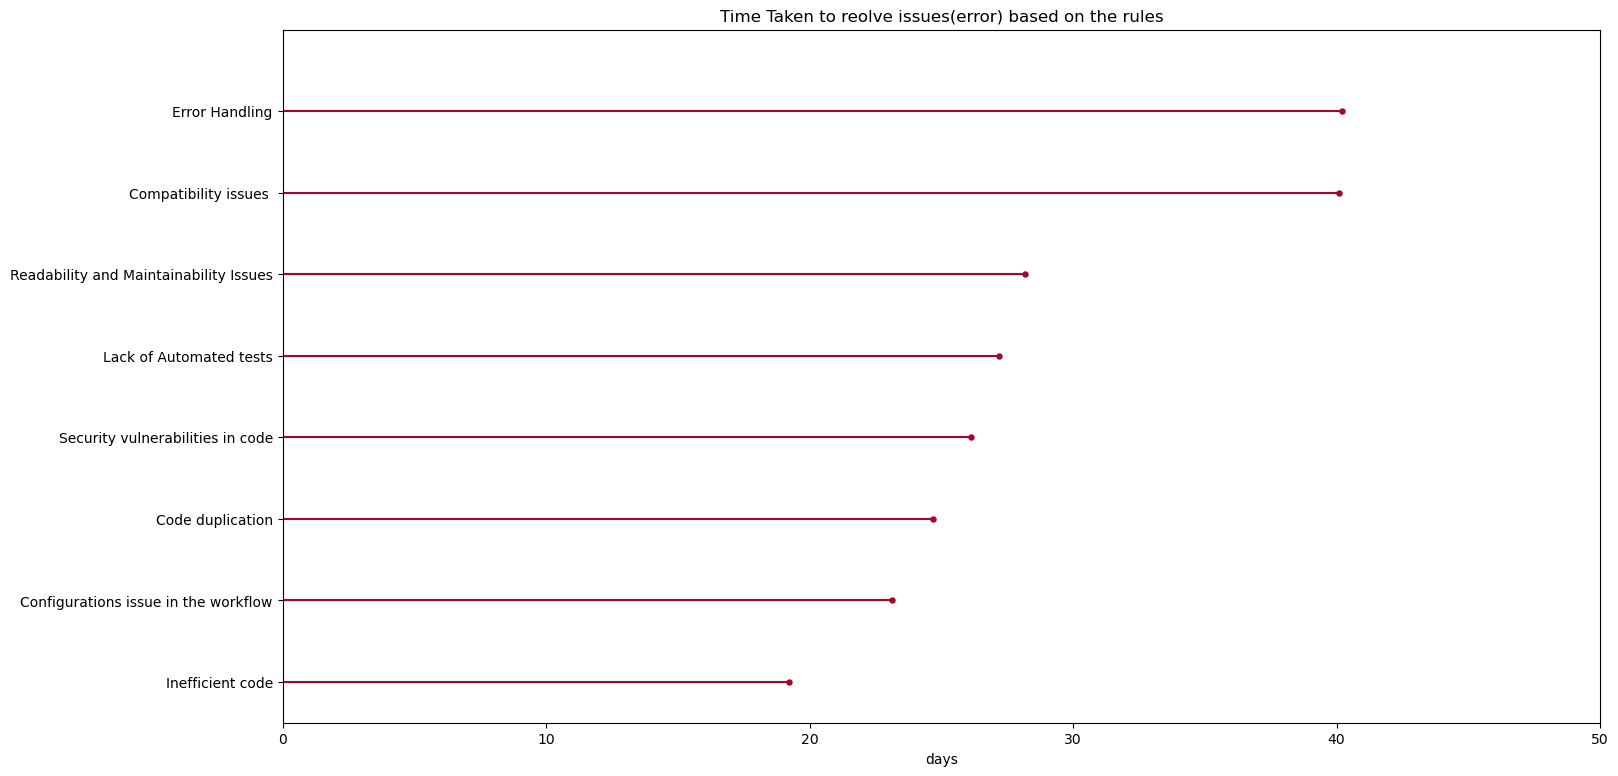

In [715]:
df['time_taken_type_change'] = pd.to_timedelta(df['time_taken'], errors='coerce')

mean_time_taken_rules = df.groupby(df.Rule)['time_taken_type_change'].mean()
components = mean_time_taken_rules.dt.components
components['days_and_hours'] = components[components.columns[0:2]].apply(
    lambda x: '.'.join(x.dropna().astype(str)),
    axis=1
)
df.drop(['time_taken_type_change'], axis=1, inplace = True)

ax = plot_lifetimes(components['days_and_hours'].astype(float))

ax.set_xlim(0, 50)
# ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("days")
ax.set_title("Time Taken to reolve issues(error) based on the rules")



In [716]:
df.columns

Index(['Unnamed: 0', 'message', 'filepath', 'line', 'column', 'kind',
       'snippet', 'end_column', 'workflow_content', 'repository', 'commit',
       'author_name', 'author_email', 'commiter_name', 'commiter_email',
       'date', 'workflow', 'change_type', 'lines_count', 'commit_year',
       'commit_mon_year', 'next_commit', 'status', 'time_taken', 'Rule'],
      dtype='object')

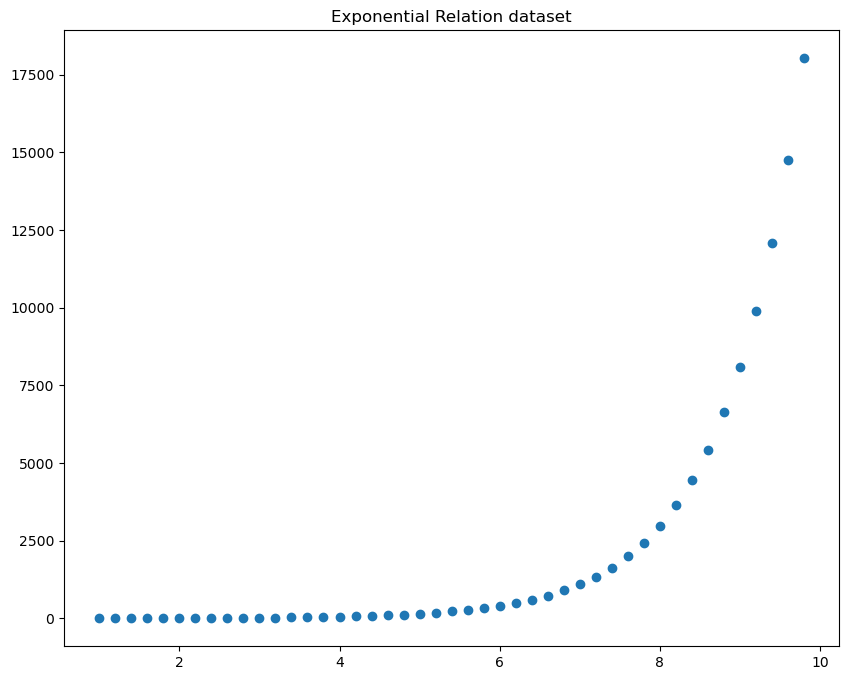

In [193]:
# Scatterplot of non-random vzriables
x=np.arange(1,10,0.2)
y= np.exp(x)
plt.scatter(x,y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Exponential Relation dataset')
plt.show()

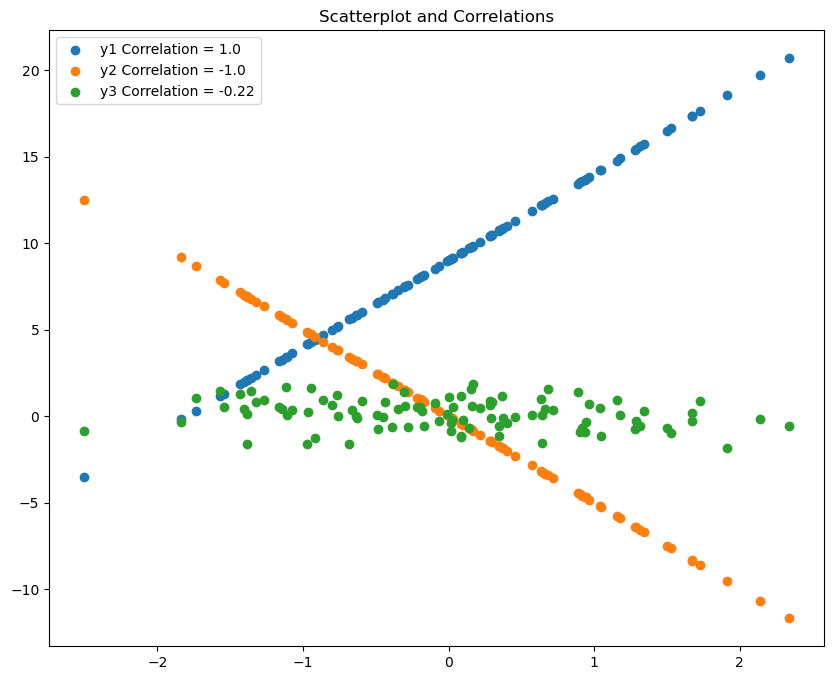

In [84]:
# Scatterplot and Correlations
# Data
x=np.random.randn(100)
y1= x*5 +9 
y2= -5*x
y3=np.random.randn(100)

# Plot
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y1, label=f'y1 Correlation = {np.round(np.corrcoef(x,y1)[0,1], 2)}')
plt.scatter(x, y2, label=f'y2 Correlation = {np.round(np.corrcoef(x,y2)[0,1], 2)}')
plt.scatter(x, y3, label=f'y3 Correlation = {np.round(np.corrcoef(x,y3)[0,1], 2)}')

# Plot
plt.title('Scatterplot and Correlations')
plt.legend()
plt.show()

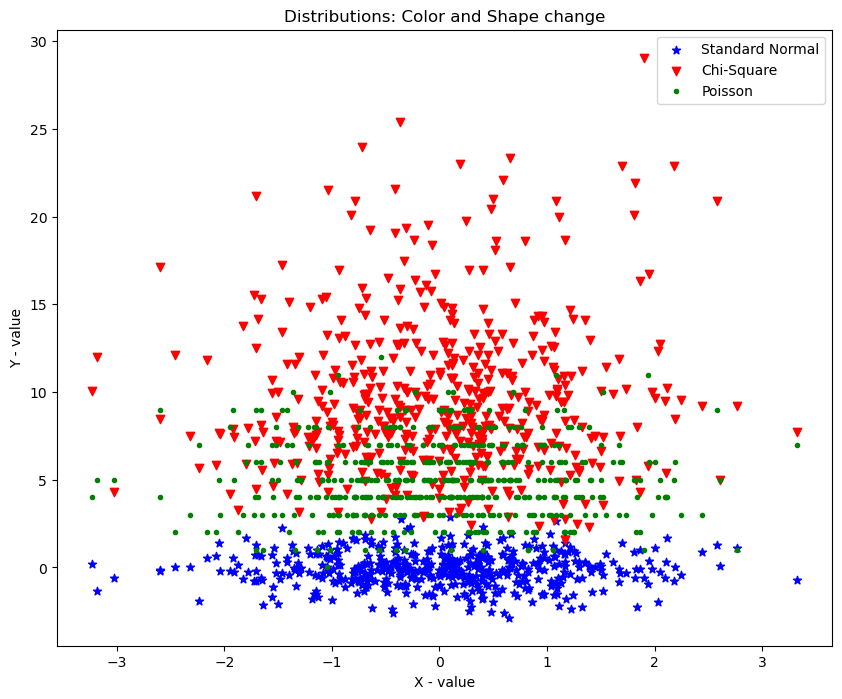

In [85]:
# Scatterplot of different distributions. Color and Shape of Points.
x = np.random.randn(500)
y1 = np.random.randn(500)
y2 = np.random.chisquare(10, 500)
y3 = np.random.poisson(5, 500)

# Plot
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x,y1,color='blue', marker= '*', label='Standard Normal')
plt.scatter(x,y2,color= 'red', marker='v', label='Chi-Square')
plt.scatter(x,y3,color= 'green', marker='.', label='Poisson')


# Decorate
plt.title('Distributions: Color and Shape change')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.legend(loc='best')
plt.show()

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_51258/2557530208.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['A'], hist=True, kde=True,


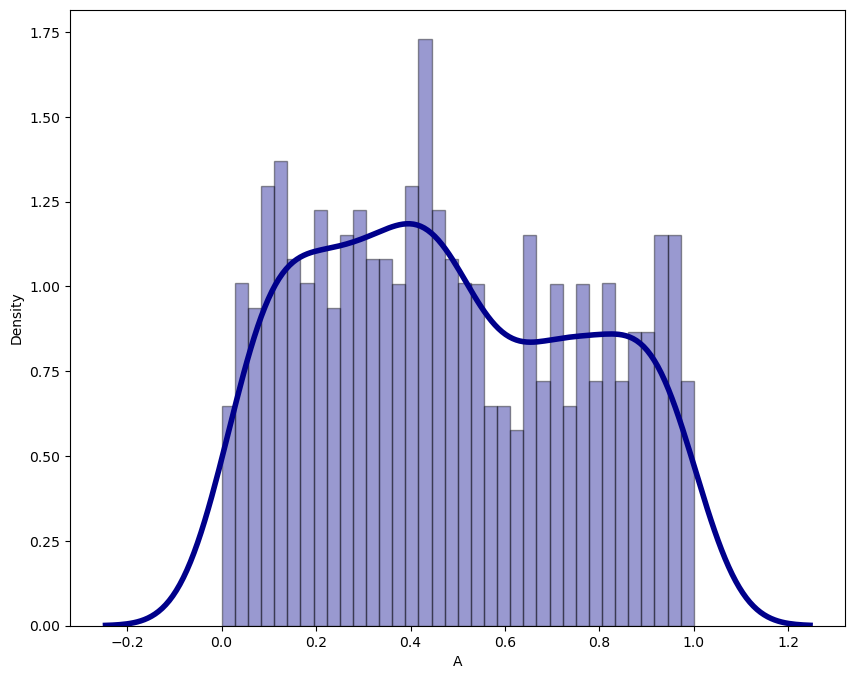

In [87]:
import seaborn as sns

df1 = pd.DataFrame(np.random.rand(500, 1), columns=['A'])
sns.distplot(df1['A'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});